In [25]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

import data_prep

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def create_input_data_from_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)

    # get list of ilocs of rows where the 'Event' column is 'GOAL or SHOT or MISS'
    goal_shot_rows = df.loc[df['Event'].isin(['GOAL', 'SHOT', 'MISS'])]

    # shift the dataframe by 1 row
    shifted_df = df.shift(1)
    shifted_df.columns = ['prev_' + name for name in df.columns]

    # combine goal_shot_rows with shifted_df, but using rows from goal_shot_rows
    goal_shot_rows = pd.concat([goal_shot_rows, shifted_df.loc[goal_shot_rows.index]], axis=1)

    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

    # Create "home_or_away" column based on if "Ev_team" is the same as "Home_Team" or "Away_Team"
    goal_shot_rows['home_or_away'] = goal_shot_rows.apply(lambda x: 'home' if x['Ev_Team'] == x['Home_Team'] else 'away', axis=1)
    
    # check to see if on power play if "home_or_away" is equal to "home" and "Strength" is equal to "5x4" or "home_or_away" is equal to "away" and "Strength" is equal to "4x5"
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "5v4" if (x['home_or_away'] == 'home' and x['Strength'] == '5x4' ) or (x['home_or_away'] == 'away' and x['Strength'] == '4x5') else "5v5", axis=1)

    # check to see if a shot is on an empty net by checking if home_or_away is equal to "home" and "Away_Goalie" is equal to "None" or home_or_away is equal to "away" and "Home_Goalie" is equal to "None"
    goal_shot_rows['on_empty_net'] = goal_shot_rows.apply(lambda x: 1 if (x['home_or_away'] == 'home' and x['Away_Goalie'] == '') or (x['home_or_away'] == 'away' and x['Home_Goalie'] == '') else 0, axis=1)


    val_input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'home_or_away', 'true_strength', 'on_empty_net', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]
    val_result_data = goal_shot_rows['Event']
    val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

    val_input_data = val_input_data.drop(columns=['Event'])

    # Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
    val_input_data_numeric = val_input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'on_empty_net','prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
    val_input_data_categorical = pd.DataFrame()

    for column in ['Type', 'prev_Event', 'true_strength', 'home_or_away']:
        dummy_columns = pd.get_dummies(val_input_data[column])
        val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

    for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
        dummy_columns = pd.get_dummies(val_input_data[column])

        # rename all columns with a prefix of "prev_"
        dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]
        val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)
        
    # change all True/False to 1/0
    val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

    # combine the two dataframes
    val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

    #set val_input_data2 to be all floats
    val_input_data_combined = val_input_data_combined.astype(float)

    columns = ['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
            'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
            'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
            'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
            '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '5x3', '5x4', '5x5', '6x5',
            'on_empty_net', 'away', 'home', '5v4', '5v5',
            'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC', 'prev_GIVE',
            'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT', 'prev_STOP',
            'prev_TAKE', 'prev_0x5', 'prev_3x3', 'prev_3x4', 'prev_3x5', 'prev_4x3',
            'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5', 'prev_5x6',
            'prev_BACKHAND', 'prev_DEFLECTED',
            'prev_PS-Covering puck in crease(0 min)',
            'prev_PS-Goalkeeper displaced net(0 min)',
            'prev_PS-Holding on breakaway(0 min)',
            'prev_PS-Hooking on breakaway(0 min)',
            'prev_PS-Slash on breakaway(0 min)',
            'prev_PS-Throw object at puck(0 min)',
            'prev_PS-Tripping on breakaway(0 min)', 'prev_SLAP SHOT',
            'prev_SNAP SHOT', 'prev_TIP-IN', 'prev_WRAP-AROUND', 'prev_WRIST SHOT']

    # For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
    for column in columns:
        if column not in val_input_data_combined.columns:
                val_input_data_combined[column] = 0

    for column in val_input_data_combined.columns:
        if column not in columns:
                if column in val_input_data_combined.columns:
                    print(f"Column {column} not in columns")
                    val_input_data_combined = val_input_data_combined.drop(column, axis=1)


    # reduce val_input_data_combined to have the same columns as input_data_combined
    val_input_data_combined = val_input_data_combined[columns]

    # change all NaN numbers to 0
    val_input_data_combined = val_input_data_combined.fillna(0)

    print(val_input_data_combined.shape)


    filepath = '0426Model_1M.pt'
    model = nn.Sequential(
        nn.Linear(77, 120),
        nn.ReLU(),
        nn.Linear(120, 60),
        nn.ReLU(),
        nn.Linear(60, 1),
        nn.Sigmoid()
    )

    model.load_state_dict(torch.load(filepath))
    model.eval()
    model.cpu()

    x = torch.tensor(val_input_data_combined.values, dtype=torch.float32)
    y = torch.tensor(val_result_data.values, dtype=torch.float32)
    result = model(x)

    # add the probability of a goal to val_input_data_combined
    goal_shot_rows['Goal_Probability'] = result.detach().numpy()

    return val_input_data_combined, val_result_data, goal_shot_rows

# Model Evaluation


First Up, single game xG creation


In [3]:
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")


C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\1544526308.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Column prev_GY #8 TANEV PS-Hooking on breakaway(0 min) not in columns
Column prev_PS-Net displaced(0 min) not in columns
(115356, 77)


In [4]:
filepath = '0426Model_1M.pt'
model = nn.Sequential(
    nn.Linear(77, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(filepath))
model.eval()
model.cpu()

x = torch.tensor(val_input_data.values, dtype=torch.float32)
y = torch.tensor(val_result_data.values, dtype=torch.float32)



In [5]:
# get the accuracy of the model
y_pred = model(x)

# convert the tensor to a numpy array
y_pred = y_pred.detach().numpy()
y = y.detach().numpy()

In [6]:


print(y_pred)
print(y)

# accuracy = (y_pred.round() == y).float().mean()\
accuracy_results = []

for i in range(len(y_pred)):
    print(f"Prediction: {y_pred[i][0]} Actual: {y[i]}")
    if y_pred[i][0].round() == y[i]:
        accuracy_results.append(1)
    else:
        accuracy_results.append(0)

accuracy = sum(accuracy_results) / len(accuracy_results)
print(f"Accuracy {accuracy}")


[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.00307451]
 [0.0190619 ]
 [0.05336122]]
[0. 0. 0. ... 0. 1. 0.]
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.06635110825300217 Actual: 0.0
Prediction: 0.022890646010637283 Actual: 0.0
Prediction: 0.00433033611625433 Actual: 0.0
Prediction: 0.024043887853622437 Actual: 0.0
Prediction: 1.9251212179938193e-08 Actual: 0.0
Prediction: 0.038137611001729965 Actual: 1.0
Prediction: 2.8514288553559002e-24 Actual: 0.0
Prediction: 0.00018500017176847905 Actual: 0.0
Prediction: 0.0071907611563801765 Actual: 0.0
Prediction: 0.03040533885359764 Actual: 0.0
Prediction: 0.000486296892631799 Actual: 0.0
Prediction: 0.03368842974305153 Actual: 0.0
Prediction: 0.6157950758934021 Actual: 0.0
Prediction: 0.013227999210357666 Actual: 0.0
Prediction: 0.0364001989364624 Actual: 0.0
Prediction: 0.0006710756570100784 Actual: 0.0
Prediction: 0.009775292128

xC
 82.0     1689
-81.0     1683
-82.0     1672
 81.0     1629
-80.0     1557
          ... 
-98.0       28
 98.0       21
 99.0       16
-99.0       11
 100.0       5
Name: count, Length: 200, dtype: int64


<Axes: xlabel='xC', ylabel='Goal_Probability'>

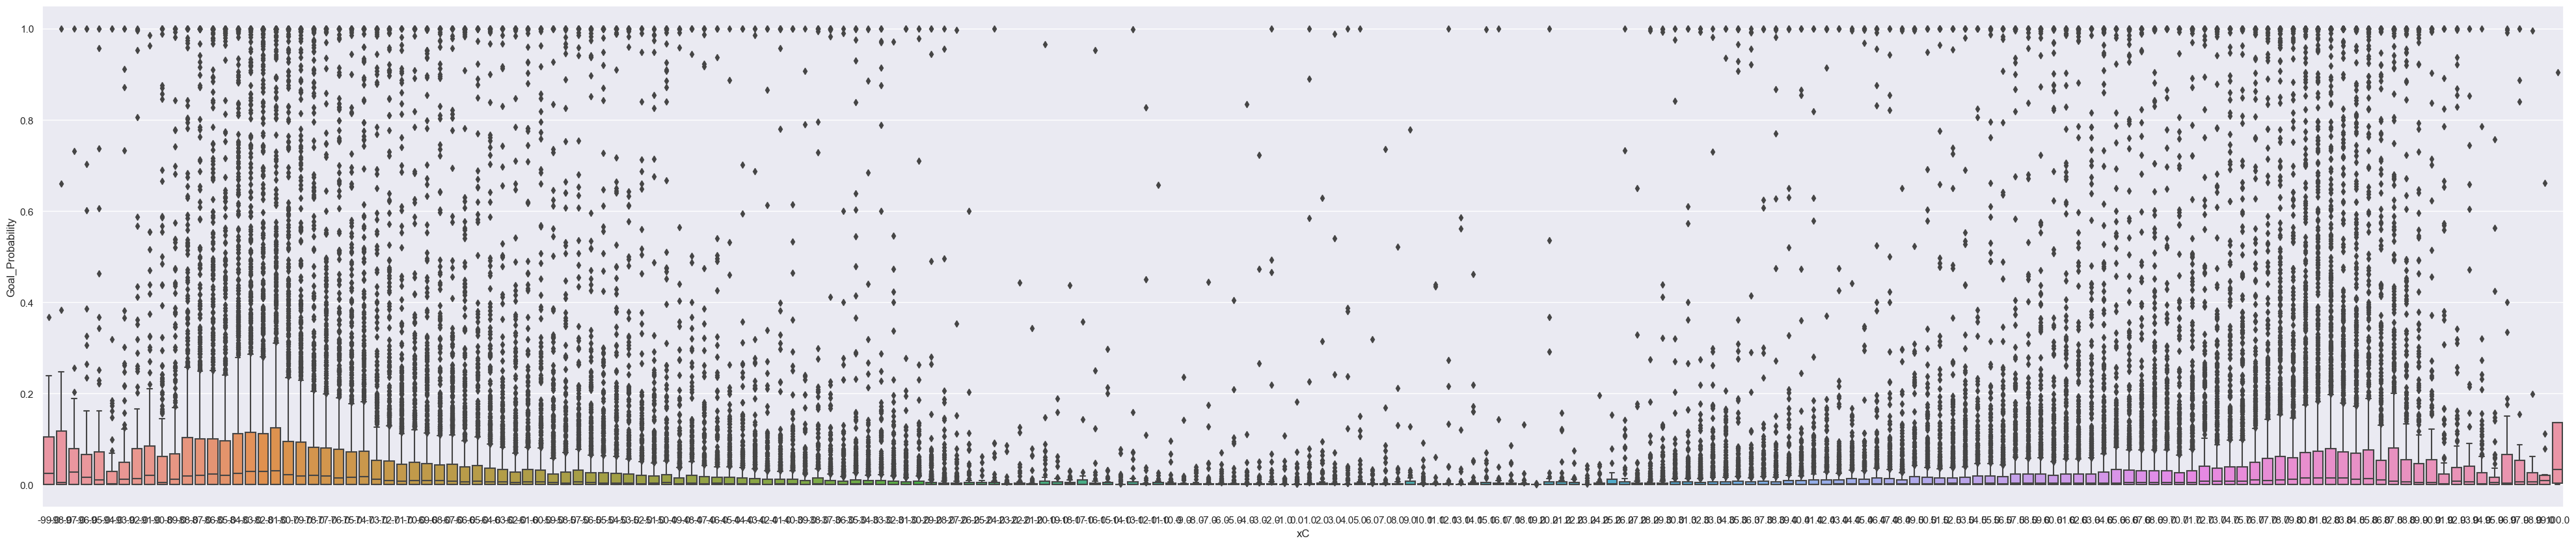

In [7]:
result = model(x)

# add the probability of a goal to val_input_data_combined
original_input['Goal_Probability'] = result.detach().numpy()

# print the values of val_input_data["Type"]
print(original_input["xC"].value_counts())

# make a boxplot of Goal_Probability vs Type
sns.set_theme(rc={'figure.figsize':(50,10)})
sns.boxplot(x=original_input["xC"], y=original_input["Goal_Probability"])
# sns.scatterplot(x=original_input["Type"], y=original_input["Goal_Probability"])


# Single Game 5v5 evaluation



In [8]:
def single_game_evaluation(original_input, game_id, state = "any"):
    game_rows = original_input[original_input["Game_Id"] == game_id]

    if state != "any":
        game_rows = game_rows[game_rows["Strength"] == state]

    # get first value of Home_Team and Away_Team
    home_team = game_rows["Home_Team"].iloc[0]
    away_team = game_rows["Away_Team"].iloc[0]

    # get all rows where the Ev_Team is the home team
    home_team_rows = game_rows[game_rows["Ev_Team"] == home_team]

    # get all rows where the Ev_Team is the away team
    away_team_rows = game_rows[game_rows["Ev_Team"] == away_team]

    # add a new column "total_xG" to home_team_rows and away_team_rows
    home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
    away_team_rows["total_xG"] = away_team_rows["Goal_Probability"].cumsum()

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    home_team_rows["Seconds_Elapsed"] = (home_team_rows["Period"] - 1) * 1200 + home_team_rows["Seconds_Elapsed"]
    home_team_rows["Minutes_Elapsed"] = home_team_rows["Seconds_Elapsed"] / 60

    # print home_team_rows to csv
    # home_team_rows.to_csv("home_team_rows.csv")

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    away_team_rows["Seconds_Elapsed"] = (away_team_rows["Period"] - 1) * 1200 + away_team_rows["Seconds_Elapsed"]
    away_team_rows["Minutes_Elapsed"] = away_team_rows["Seconds_Elapsed"] / 60

    # away_team_rows.to_csv("away_team_rows.csv")

    total_home_xG = home_team_rows["total_xG"].iloc[-1].round(2)
    total_away_xG = away_team_rows["total_xG"].iloc[-1].round(2)

    # combine home_team_rows and away_team_rows into one dataframe
    combined_rows = pd.concat([home_team_rows, away_team_rows])

    home_score = home_team_rows["Home_Score"].iloc[-1]
    away_score = away_team_rows["Away_Score"].iloc[-1]

    return combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score


(91, 77)


C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\1544526308.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)
C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\1266343489.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\1266343489.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

<Axes: title={'center': 'TOR (2.26) vs BOS (2.41)'}, xlabel='Minutes_Elapsed', ylabel='total_xG'>

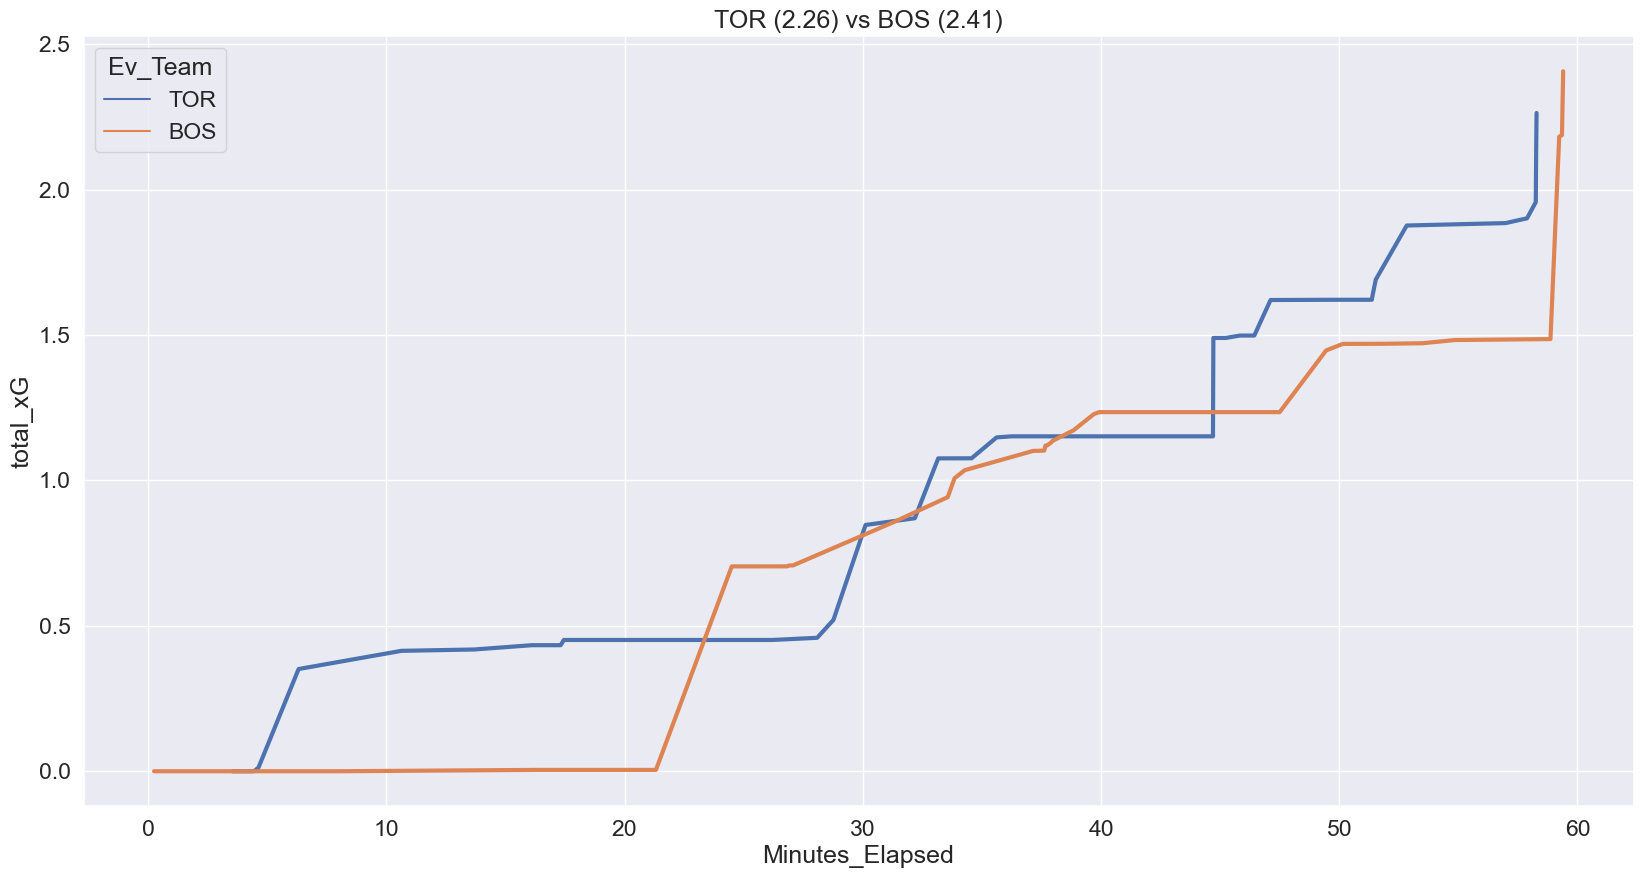

In [9]:
game_id = 30123

val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_1714030348.csv")


combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = single_game_evaluation(original_input, game_id, "any")

# print combined rows to csv
combined_rows.to_csv("combined_rows.csv")

# plot the total_xG of the home team
float_formatter = "{:.2f}".format
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.set_theme(style="darkgrid", font='Arial', font_scale=1.5, color_codes=True, rc=None)
# set title to [home_team] vs [away_team]
plt.title(f"{home_team} ({float_formatter(total_home_xG)}) vs {away_team} ({float_formatter(total_away_xG)})")
sns.lineplot(data=combined_rows, x="Minutes_Elapsed", y="total_xG", hue="Ev_Team", linewidth = 3)


# Full Season Rolling Evaluation

Rough idea is as follows:

- For the first 20 games of each team's season, just tally the team's XG% (all situations)
- From then on out (assuming both teams have 20 games), take the avg xG% of each teams last 20 games, then compare/normalize to 100%. Figure out who the winner was, and mark that as a correct prediction, or a failure.

In [10]:
# read in nhl_pbp_20232024.csv
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")







C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\1544526308.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Column prev_GY #8 TANEV PS-Hooking on breakaway(0 min) not in columns
Column prev_PS-Net displaced(0 min) not in columns
(115356, 77)


In [32]:
# split original_input into multiple dataframes based off of game_id
game_ids = original_input["Game_Id"].unique()
# remove all instances of game_ids that start with 3
game_ids = [x for x in game_ids if str(x)[0] != "3"]

nhl_teams = {}

results = []
predictions = []
predictions_rounded = []

for game_id in game_ids:
    # print(f"Game ID: {game_id}")
    combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = single_game_evaluation(original_input, game_id, "any")

    # add the total_xG of the home team and away team to nhl_teams
    if home_team not in nhl_teams:
        nhl_teams[home_team] = {"xG_percent": [], "total_games": 0}
    if away_team not in nhl_teams:
        nhl_teams[away_team] = {"xG_percent": [], "total_games": 0}

    # if both teams have more than 20 games played, create a prediciton for the game
    if nhl_teams[home_team]["total_games"] >= 20 and nhl_teams[away_team]["total_games"] >= 20:
        # get the average of last 20 games for home_team and away_team
        # home_xG_percent_avg = np.mean(nhl_teams[home_team]["xG_percent"])
        # away_xG_percent_avg = np.mean(nhl_teams[away_team]["xG_percent"])

        # home_xG_percent_avg = home_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)
        # away_xG_percent_avg = away_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)

        # # Apply linear decay to each home_team's xg_percent game by game
        decay_rate = 0.01  # Adjust the decay rate as desired

        # Calculate the decayed xg_percent for each game
        home_decayed_xg_percent = np.zeros_like(nhl_teams[home_team]["xG_percent"])
        len_home_games = len(nhl_teams[home_team]["xG_percent"])
        for i in range(len_home_games):
            home_decayed_xg_percent[i] = nhl_teams[home_team]["xG_percent"][(len_home_games - i -1 )] * (1 - (decay_rate * i))

        away_decayed_xg_percent = np.zeros_like(nhl_teams[away_team]["xG_percent"])
        len_away_games = len(nhl_teams[away_team]["xG_percent"])
        for i in range(len_away_games):
            away_decayed_xg_percent[i] = nhl_teams[away_team]["xG_percent"][(len_away_games - i - 1)] * (1 - (decay_rate * i))

        home_xG_percent_sum = np.sum(home_decayed_xg_percent)
        away_xG_percent_sum = np.sum(away_decayed_xg_percent)
        
        home_xG_percent_avg = home_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)
        away_xG_percent_avg = away_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)

        results.append(home_score > away_score)
        predictions.append(home_xG_percent_avg)
        predictions_rounded.append(home_xG_percent_avg.round())

        # if home_xG_percent_avg > away_xG_percent_avg:
        #     print(f"{home_xG_percent_avg}")
        # else:
        #     print(f"{away_xG_percent_avg}")

    home_xG_percent = total_home_xG / (total_home_xG + total_away_xG)
    away_xG_percent = total_away_xG / (total_home_xG + total_away_xG)

    nhl_teams[home_team]["xG_percent"].append(home_xG_percent)
    nhl_teams[away_team]["xG_percent"].append(away_xG_percent)
    nhl_teams[home_team]["total_games"] += 1
    nhl_teams[away_team]["total_games"] += 1

0.5420058369636536
0.6052648425102234
0.5084973573684692
0.5047791600227356
0.5577408075332642
0.5161657333374023
0.5013700127601624
0.5437013506889343
0.5194510221481323
0.503748893737793
0.521700382232666
0.5048378705978394
0.6067094802856445
0.5477880835533142
0.5601763129234314
0.5378932952880859
0.5395203232765198
0.5394911170005798
0.5593812465667725
0.5480971336364746
0.5415798425674438
0.5105369687080383
0.5222593545913696
0.5258839726448059
0.5384680032730103
0.587575376033783
0.5368561148643494
0.5582411289215088
0.5217543244361877
0.5775926113128662
0.5399008989334106
0.5208901762962341
0.5342205166816711
0.5218937993049622
0.5413108468055725
0.522254228591919
0.5198091864585876
0.5723584294319153
0.505556583404541
0.5858021974563599
0.5143669843673706
0.5148743391036987
0.5332744121551514
0.5289566516876221
0.535274863243103
0.5563844442367554
0.52543044090271
0.526175320148468
0.5827513337135315
0.5015423893928528
0.5001050233840942
0.5316726565361023
0.5386731028556824
0.

In [18]:
# get the accuracy of the model
results_tensor = torch.tensor(results, dtype=torch.float32)
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

# calculate log loss of predicitons
log_loss = nn.BCELoss()
log_loss_results = log_loss(predictions_tensor, results_tensor)

print(f"Accuracy {accuracy}")
print(f"log loss {log_loss_results}")

Accuracy 0.592252790927887
log loss 0.6814600229263306


In [22]:
# for each team in nhl_teams, get the avg xG% over the last 20 games played and sort
team_xG_percent = {}
for team in nhl_teams:
    if nhl_teams[team]["total_games"] >= 20:
        team_xG_percent[team] = np.mean(nhl_teams[team]["xG_percent"][-20:])
    else:
        team_xG_percent[team] = 0

sorted_team_xG_percent = dict(sorted(team_xG_percent.items(), key=lambda item: item[1], reverse=True))

for key, value in sorted_team_xG_percent.items():
    print(f'{key}:  {value}')


nhl_team_strength = {}

for team in nhl_teams:
    decayed_xg_percent = np.zeros_like(nhl_teams[team]["xG_percent"])
    len_games_games = len(nhl_teams[team]["xG_percent"])
    for i in range(len_games_games):
        decayed_xg_percent[i] = nhl_teams[team]["xG_percent"][(len_games_games - i - 1)] * (1 - (decay_rate * i))

    nhl_team_strength[team] = np.sum(decayed_xg_percent)

sorted_team_xG_total = dict(sorted(nhl_team_strength.items(), key=lambda item: item[1], reverse=True))

print("\n\n Team Strength")

for key, value in sorted_team_xG_total.items():
    print(f'{key}:  {value}')



DAL:  0.6184804439544678
TOR:  0.606242835521698
CAR:  0.6006478071212769
EDM:  0.5836714506149292
COL:  0.5825635194778442
NYR:  0.5825018882751465
PHI:  0.5670269727706909
MIN:  0.5386543273925781
VGK:  0.5330008268356323
L.A:  0.5286811590194702
WPG:  0.5239684581756592
CGY:  0.521574854850769
PIT:  0.5136874914169312
T.B:  0.5036930441856384
DET:  0.49850043654441833
N.J:  0.4973631501197815
BOS:  0.492567241191864
SEA:  0.4884616434574127
OTT:  0.48455357551574707
NSH:  0.48125991225242615
VAN:  0.4789585471153259
STL:  0.47268158197402954
NYI:  0.4715380072593689
ARI:  0.46889251470565796
BUF:  0.4624084532260895
CHI:  0.4619343876838684
FLA:  0.4560371935367584
MTL:  0.45393115282058716
ANA:  0.41837558150291443
CBJ:  0.4128723740577698
S.J:  0.4055290222167969
WSH:  0.3911282420158386


 Team Strength
CAR:  28.4175968170166
EDM:  27.791072845458984
DAL:  27.211902618408203
TOR:  27.05150032043457
PHI:  26.966554641723633
COL:  26.751081466674805
FLA:  26.088457107543945
PIT:  2